<a href="https://colab.research.google.com/github/Vadiman728/Upscaling-with-autoencoder/blob/main/Upscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upscaling с помощью автокодировщика

В этом блокноте реализуем простую модель для повышения качества изображений

 # Импорт библиотек

Импортируем библиотеки и датасет с площадки соревнований по ml- kaggle

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.regularizers import l2
import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("Path to dataset files:", path)

100%|██████████| 112M/112M [00:06<00:00, 19.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


# Теоретическая часть

Проблема повышения качества изображения стоит особенно остро в сфере компьютерного зрения а именно: медицина, высокоточное производство, опасные производства или исследования.

Такую модель можно использовать тогда, когда установлено бюджетное оборудование и нет возможности получать высококачественные снимки для их использования

## Математическое обоснование


Структура автокодировщика:
Автокодировщик состоит из кодировщика
f
f и декодировщика
g
g. Кодировщик генерирует скрытое представление
z
z из входного изображения
x
x:

z
=
f
(
x
)
z=f(x)
Декодировщик восстанавливает изображение
x
^
x
^
  из скрытого представления:

x
^
=
g
(
z
)
x
^
 =g(z)
Функция потерь:
Для оценки качества восстановления используется функция потерь. В данном случае мы используем среднеквадратичную ошибку (MSE):

L
(
x
,
x
^
)
=
1
N
∑
i
=
1
N
(
x
i
−
x
^
i
)
2
L(x,
x
^
 )=
N
1
​
  
i=1
∑
N
​
 (x
i
​
 −
x
^
  
i
​
 )
2

Регуляризация:
Для повышения обобщающей способности модели и предотвращения переобучения применяется L2-регуляризация. Регуляризация добавляет штраф к функции потерь за сложность модели, что помогает избежать переобучения:

L
r
e
g
=
λ
∑
j
w
j
2
L
reg
​
 =λ
j
∑
​
 w
j
2
​

где
λ
λ — коэффициент регуляризации (в коде установлен на
0.01
0.01), а
w
j
w
j
​
  — веса сверток.

Общая функция потерь:
Общая функция потерь с учетом регуляризации будет выглядеть следующим образом:

L
t
o
t
a
l
=
L
(
x
,
x
^
)
+
L
r
e
g
L
total
​
 =L(x,
x
^
 )+L
reg
​

Это означает, что мы минимизируем не только ошибку восстановления, но и сложность модели.

# Подготовка данных

Kaggle скачивает датасет в свою папку. Нам удобнее работать в своей, потому перместим

In [ ]:
!mv /root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/* /content/

Зафиксируем расположение картинок

In [ ]:
face_images = glob.glob('/content/4/lfw-deepfunneled/lfw-deepfunneled/**/*.jpg')

Собираем всю выборку

In [ ]:
all_images = []

for i in tqdm(face_images):
  img = image.load_img(i, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  all_images.append(img)

100%|██████████| 13233/13233 [00:09<00:00, 1410.42it/s]


Смотрим на 5 образцов

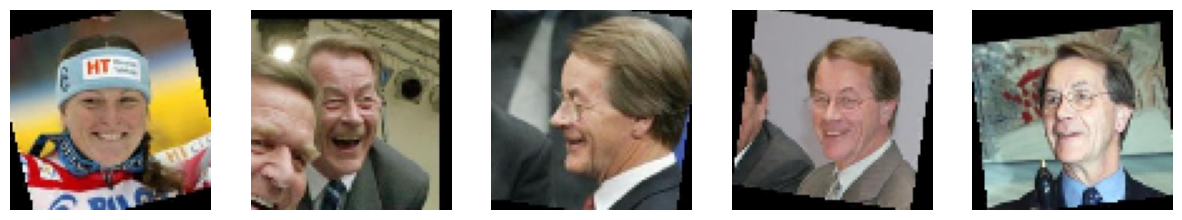

In [ ]:
plt.figure(figsize=(15, 5))
for index in range(5):
    plt.subplot(1, 5, index + 1)  # 1 строка, 5 столбцов
    plt.imshow(all_images[index])
    plt.axis('off')  # Отключаем оси
plt.show()

Преобразуем изображения в массив и делим на выборки

In [ ]:

all_images = np.array(all_images)

# split data into train and validation data
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.1)

Видно, что наши изображения хорошего качества. Нам этого не надо, потому мы пишем короткую функцию, которая уменьшает, а затем снова расширяет изображение. В итоге мы получаем изображение сжатое в 40 раз

In [ ]:
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [ ]:
train_x_px = []

for i in range(train_x.shape[0]): # цикл по всем изображениям
  temp = pixalate_image(train_x[i,:,:,:]) # Каждое изображение попадает в функцию и возвращается пикселизированная версия
  train_x_px.append(temp) # пиксельная версия записывается. Именно она будет учавствовать в обучении

train_x_px = np.array(train_x_px)

val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

В итоге мы получаем пикселизированные изображения

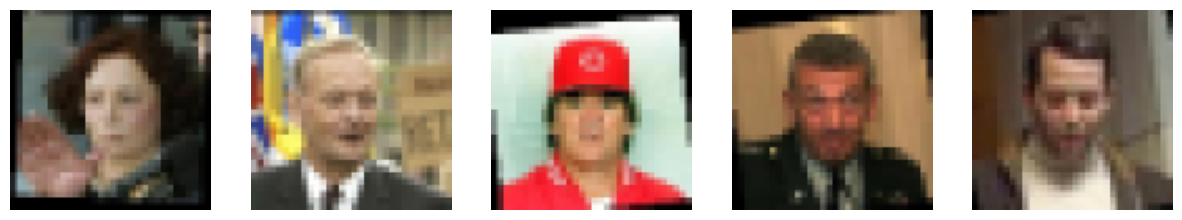

In [ ]:
plt.figure(figsize=(15, 5))
for index in range(5):
    plt.subplot(1, 5, index + 1)  # 1 строка, 5 столбцов
    plt.imshow(train_x_px[index])
    plt.axis('off')  # Отключаем оси
plt.show()

# Архитектура модели

Как и писалось выше, для нашей задачи будет небольшая модель с уменьшенными входом в виду ограничений среды

Так же добавим L2 регуляризацию чтобы улучшить качество моделей (о каком качестве в изображениях 80 на 80 идет речь, неизвестно, но пусть будет)

In [ ]:
Input_img = Input(shape=(80, 80, 3))

# Encoding architecture with L2 regularization
x1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1)
x2 = MaxPooling2D((2, 2))(x2)  # Латентное пространство
encoded = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x2)

# Decoding architecture with L2 regularization
x3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80, 80, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 80, 80, 256)         │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 80, 80, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 40, 40, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 80, 80, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 80, 80, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 80, 80, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 80, 80, 3)           │           6,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 788,867 (3.01 MB)

 Trainable params: 788,867 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

# Обучение

У меня выкинуло среду перед срабатыванием стопа, но она разрешила дообучить модель

In [ ]:
# делаем ранний стоп, если потеря на валидационной выборке не будет уменьшаться в течение 3 эпох
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')

autoencod = autoencoder.fit(train_x_px, train_x,
            epochs=50,
            batch_size=256,
            shuffle=True,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper])

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - loss: 3.6771 - val_loss: 0.6987
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 0.5552 - val_loss: 0.3073
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.2692 - val_loss: 0.1824
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 0.1639 - val_loss: 0.1203
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.1090 - val_loss: 0.0833
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 0.0776 - val_loss: 0.0626
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0588 - val_loss: 0.0490
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0472 - val_loss: 0.0403
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 0.0387 - val_loss: 0.0344
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0344 - val_loss: 0.0305
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0298 - val_loss: 0.0275
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 0.0272 - val_l

# Оценка результатов

Ничего лучше не показывает действие модели по апскалингу как сравнение до-после

In [ ]:
predictions = autoencoder.predict(val_x_px)

In [ ]:

n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

# Выводы

Модель показала хорошие результаты. Как видно из выведенных изображений- округлости восстановлены и черты лица так же хорошо показываются.

На бОльших мощностях, конечно, можно построить архитектуру побольше, взять больше тренировочных изображений и сохранить их размерность (или привести к чему-то большему, чем 40 на 40)